In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../scripts/')
import config as cfg
sys.path.append('../scripts/crnn/')


# Comparison

In [4]:
def plot_cm(targets, preds, genres, title, labels_order=None):
    cm = confusion_matrix(targets, preds, labels=labels_order)
    norm_cm = np.around((cm.T/np.sum(cm, axis=1)).T, 2)
    plt.figure(dpi=150)
    sns.heatmap(norm_cm, annot=True, cmap='Blues')
    tick_marks = np.arange(len(genres))
    plt.xticks(tick_marks, genres, rotation=45)
    plt.yticks(tick_marks, genres, rotation=0)

    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')

In [5]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, precision_recall_curve, roc_curve

## Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV

In [21]:
genres_map_rf = {'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

genres_rf = list(genres_map_rf.keys())

In [11]:
data = pd.read_csv('../data/GTZAN/data.csv', index_col='filename')

X = data.drop('label', axis=1)
y = data['label']
y = y.apply(lambda x: genres_map_rf[x])

# scaler = StandardScaler()
# X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=data.label)

In [25]:
np.random.seed(23)
parameters = {'n_estimators':range(50, 500, 50)}
RFC_CV = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameters, cv=5)

In [26]:
RFC_CV.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': range(50, 500, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [27]:
RFC_CV.best_estimator_.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>

In [28]:
accuracy_score(y_test, RFC_CV.predict(X_test))

0.63200000000000001

In [30]:
features = data.columns[:-1]

In [31]:
features[np.argsort(RFC_CV.best_estimator_.feature_importances_)[::-1]][:10]

Index(['chroma_stft', 'mfcc4', 'rmse', 'mfcc1', 'mfcc3', 'mfcc11', 'mfcc9',
       'spectral_bandwidth', 'mfcc5', 'mfcc14'],
      dtype='object')

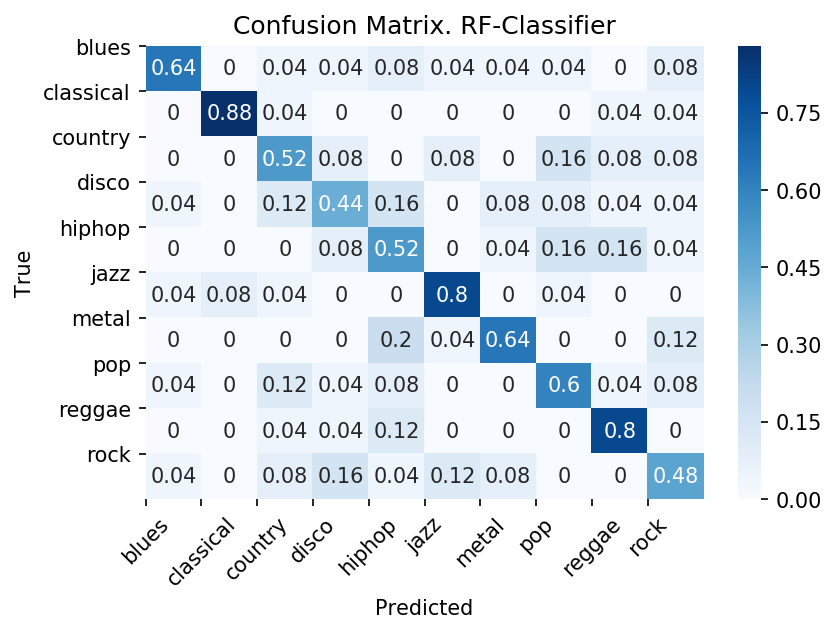

In [33]:
plot_cm(y_test,  RFC_CV.predict(X_test), genres_rf, title='Confusion Matrix. RF-Classifier')

In [36]:
y_pred_rfc = RFC_CV.predict(X_test)

res_vals_rfc = []
for i in range(0, 10):
    args = np.where(y_test == i)[0]
    res_vals_rfc.append(accuracy_score(y_test[args], y_pred_rfc[args]))
res_vals_rfc = np.around(np.array(res_vals_rfc), 3)

### ANFIS

In [37]:
genres_map_anfis = {'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

genres_anfis = list(genres_map_anfis.keys())

In [38]:
def get_anfis_results(filename):
    res_path =  '/home/stasdon/git/musicgenrerecognition/data/GTZAN/' + filename
    with open(res_path) as f:
        results = f.readlines()
    results = np.array([[r.split()[0], r.split()[1]] for r in results])
    target = results[:, 1].astype(int)
    preds = results[:, 0].astype(int)
    
    plot_cm(target, preds, genres_anfis, title='Confusion Matrix. ANFIS')
    
    res_vals_anfis = []
    for i in range(1,11):
        args = np.where(target == i)
        res_vals_anfis.append(accuracy_score(target[args], preds[args]))
    res_vals_anfis = np.around(np.array(res_vals_anfis), 3)
    return res_vals_anfis

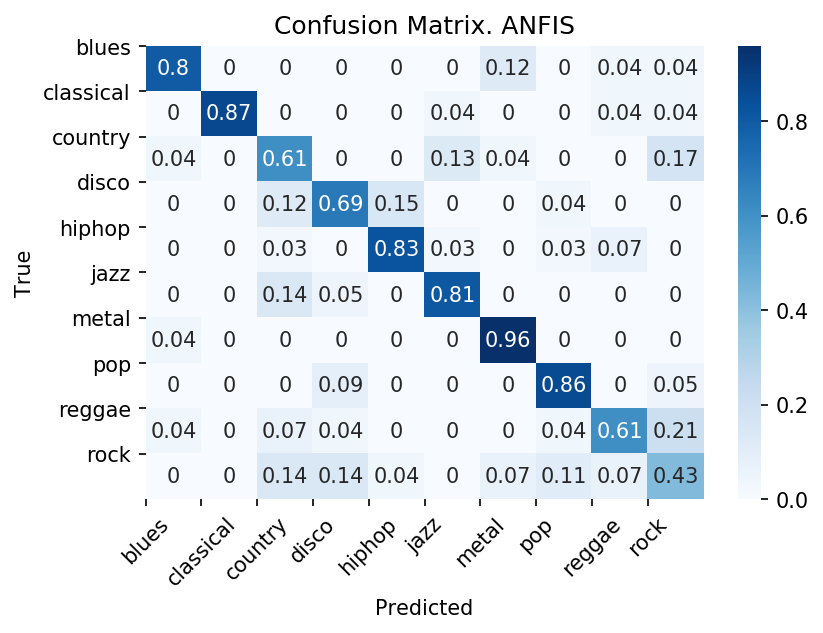

In [39]:
anfis_all_res = get_anfis_results('anfis_all_feats')

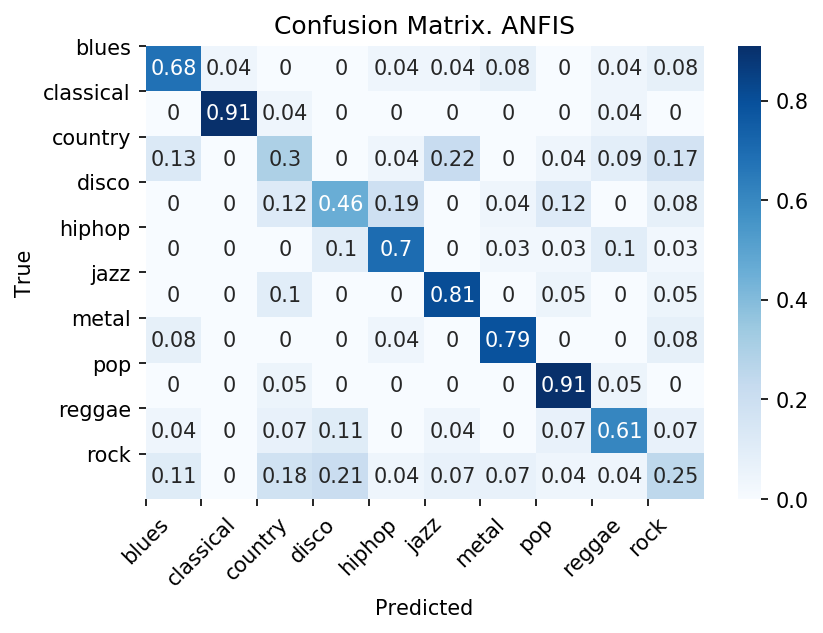

In [40]:
anfis_10_res = get_anfis_results('anfis_10_feats')

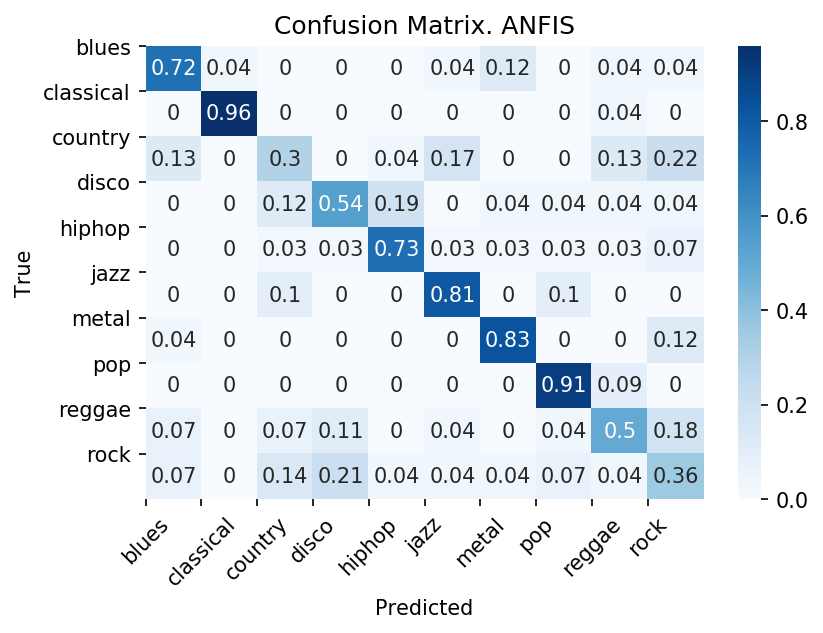

In [41]:
anfis_15_res = get_anfis_results('anfis_15_feats')

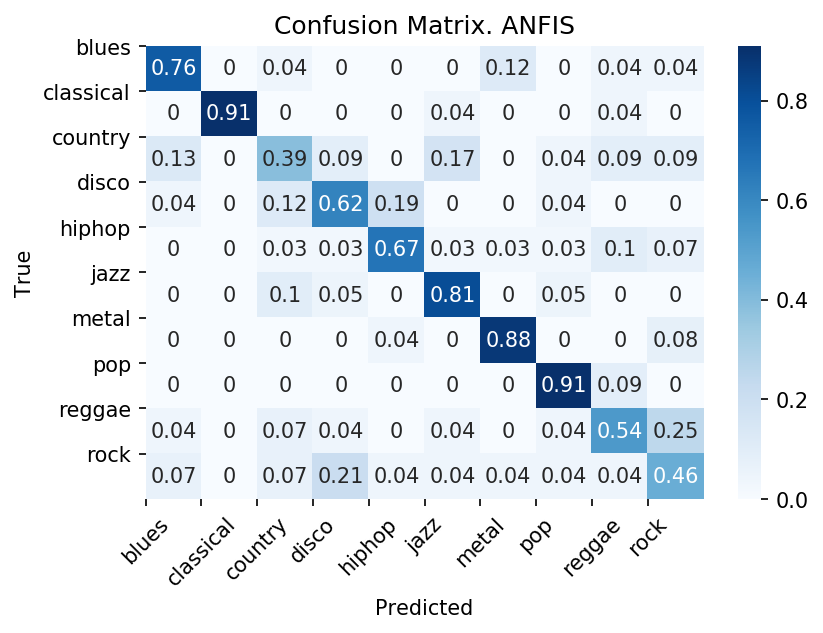

In [42]:
anfis_20_res = get_anfis_results('anfis_20_feats')

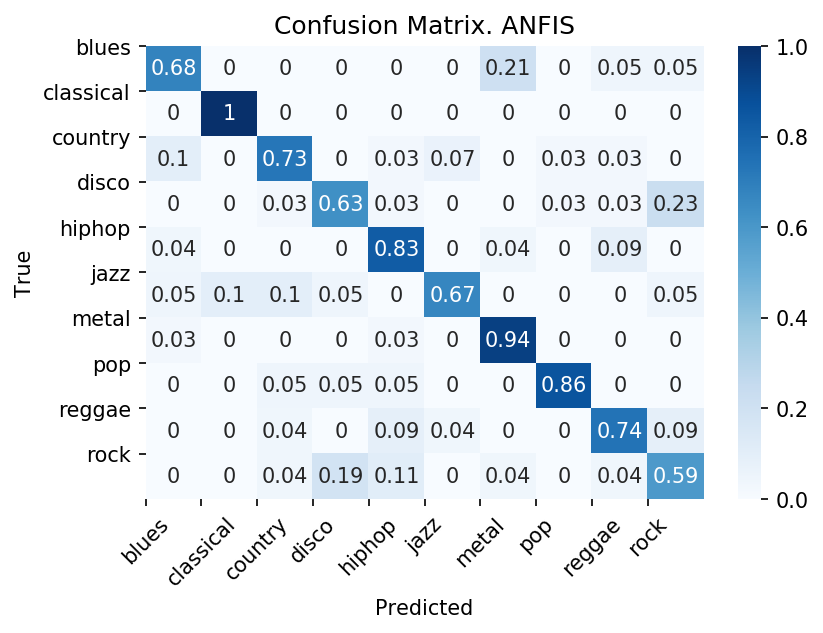

In [43]:
anfis_scaled_res = get_anfis_results('anfis_scaled_feats')

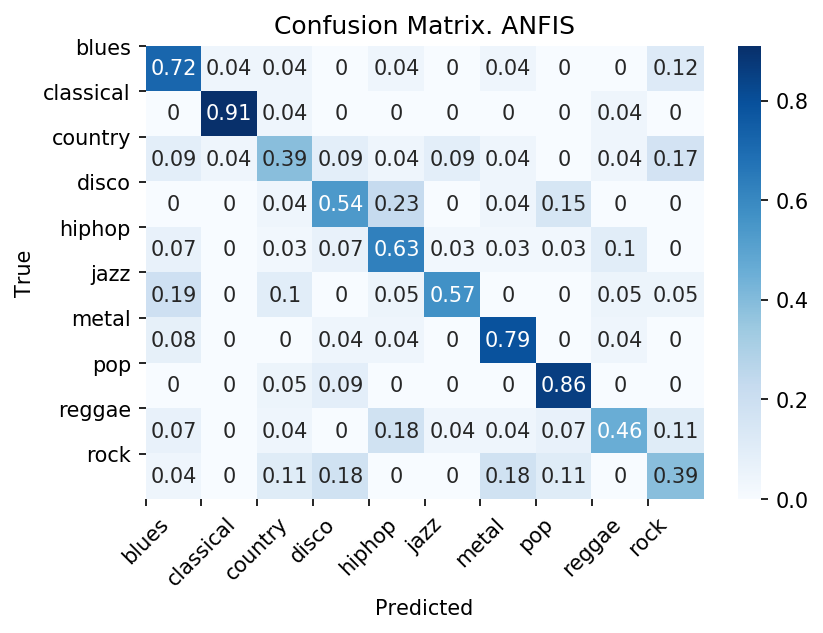

In [44]:
anfis_l20_res = get_anfis_results('anfis_l20_feats')

In [45]:
anfis_res_df = pd.DataFrame(np.column_stack((list(genres_map_anfis.keys()), anfis_all_res, anfis_10_res, 
                                       anfis_15_res, anfis_20_res, anfis_l20_res , anfis_scaled_res)), 
                      columns=['Genre', 'All Feat-s', 'Top10 Feat-s', 'Top15 Feat-s', 'Top20 Feat-s', 'Last20 Feat-s', 'All scaled'])
anfis_res_df.set_index(['Genre'])

,All Feat-s,Top10 Feat-s,Top15 Feat-s,Top20 Feat-s,Last20 Feat-s,All scaled
Genre,,,,,,
blues,0.8,0.68,0.72,0.76,0.72,0.684
classical,0.87,0.913,0.957,0.913,0.913,1.0
country,0.609,0.304,0.304,0.391,0.391,0.733
disco,0.692,0.462,0.538,0.615,0.538,0.633
hiphop,0.833,0.7,0.733,0.667,0.633,0.826
jazz,0.81,0.81,0.81,0.81,0.571,0.667
metal,0.958,0.792,0.833,0.875,0.792,0.938
pop,0.864,0.909,0.909,0.909,0.864,0.864
reggae,0.607,0.607,0.5,0.536,0.464,0.739


In [46]:
anfis_res_df[list(set(anfis_res_df.columns) - set(['Genre']))] = anfis_res_df[list(set(anfis_res_df.columns) - set(['Genre']))].astype(float)
anfis_res_df.mean(axis=0)


All Feat-s       0.7472
Top10 Feat-s     0.6427
Top15 Feat-s     0.6661
Top20 Feat-s     0.6940
Last20 Feat-s    0.6279
All scaled       0.7677
dtype: float64

### Simple Fully-Connected NN

In [47]:
import keras
from keras import models
from keras import layers

In [48]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [49]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [50]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)

In [51]:
model.fit(X_train_scaled, y_train.values, nb_epoch=20, batch_size=128, verbose=False)

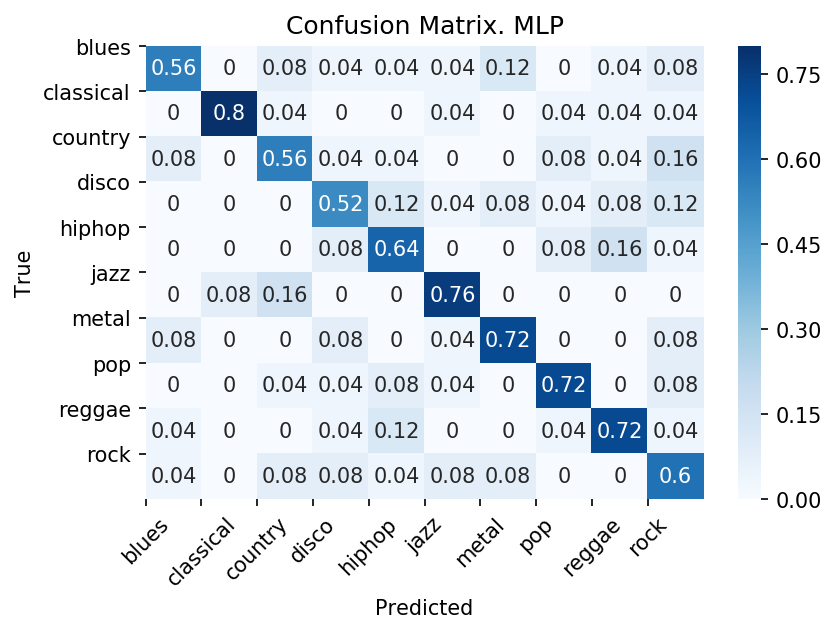

In [52]:
y_pred_mlp = np.argmax(model.predict(sc.transform(X_test)), axis=1)

plot_cm(y_test, y_pred_mlp, genres_rf, title='Confusion Matrix. MLP')

In [53]:
res_vals_mlp = []
for i in range(0, 10):
    args = np.where(y_test == i)[0]
    res_vals_mlp.append(accuracy_score(y_test[args], y_pred_mlp[args]))
res_vals_mlp = np.around(np.array(res_vals_mlp), 3)

In [54]:
res_vals_mlp.mean()

0.65999999999999992

### CNN

In [55]:
import pickle

In [56]:
with open(cfg.DATASET_PATH + 'genres_map.pckl', 'rb') as f:
    genres_map = pickle.load(f)
genres = list(genres_map.keys())

In [57]:
g_to_anfis = []
for ga in genres_anfis:
    for i, g in enumerate(genres):
        if g == ga:
            g_to_anfis.append(i)

In [58]:
from genre_rec_CNN import GenreRecCNN
import os
import pickle
from sklearn.model_selection import train_test_split
from keras.utils import np_utils


In [59]:
if os.path.exists(cfg.DATASET_PATH + 'features.pckl'):
    with open(cfg.DATASET_PATH + 'features.pckl', 'rb') as f:
        X = pickle.load(f)
    with open(cfg.DATASET_PATH + 'targets.pckl', 'rb') as f:
        y = pickle.load(f)
        


In [60]:
nb_classes = 10

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=23)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, stratify=y_test, test_size=0.5, random_state=23)

In [62]:
y_test = np.array(y_test)

In [63]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_val = np_utils.to_categorical(y_val, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [64]:
model_cnn = GenreRecCNN(weights='msd', input_tensor=(1, 96, 1366))
model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [65]:
model_cnn.load_weights('/home/stasdon/git/temp/musicgenrerecognition/scripts/crnn/models_trained/cnn_net_adam_GTZAN_OLD/weights/01-0.89.hdf5')

In [67]:
preds_cnn = model_cnn.predict(X_test, batch_size=128, verbose=1)

165/165 [==============================] - 63s     


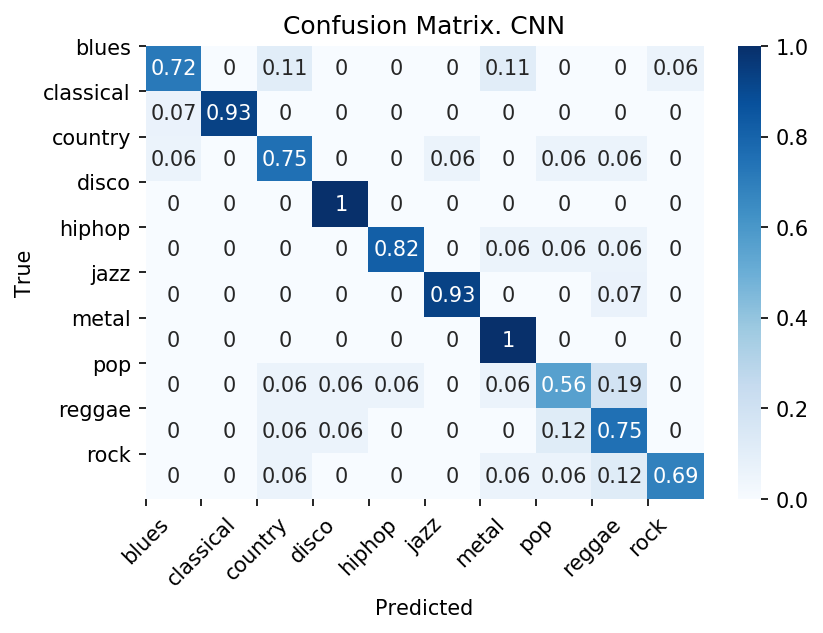

In [68]:
y_pred_cnn = np.argmax(preds_cnn, axis=1)
plot_cm(y_test, y_pred_cnn, np.array(genres)[g_to_anfis], labels_order=g_to_anfis, title='Confusion Matrix. CNN')

In [69]:
res_vals_cnn = []
for i in g_to_anfis:
    args = np.where(y_test == i)
    res_vals_cnn.append(accuracy_score(y_test[args], y_pred_cnn[args]))
res_vals_cnn = np.around(np.array(res_vals_cnn), 3)

### Mel-spectrograms samples

In [70]:
import librosa
import librosa.display
from audio_processor import compute_melgram

ModuleNotFoundError: No module named 'audio_processor'

In [41]:
labels_df = pd.read_csv(cfg.LABELS_PATH)

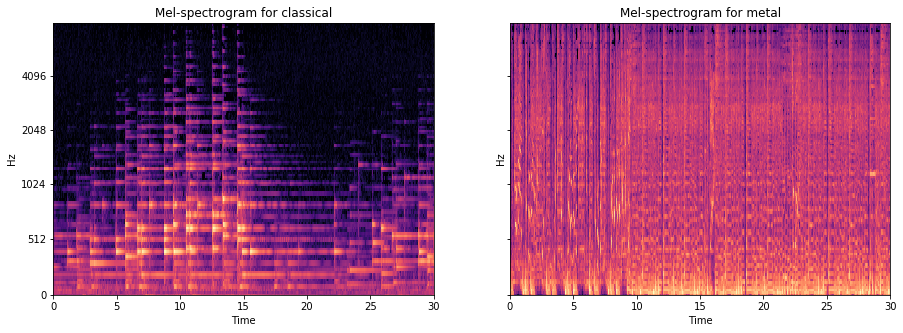

In [62]:
_, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 5)) 
y, sr = librosa.load(cfg.AUDIO_DIR + labels_df.iloc[501].track_id)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time', ax=ax[0])
ax[0].set_title('Mel-spectrogram for classical')

y, sr = librosa.load(cfg.AUDIO_DIR + labels_df.iloc[101].track_id)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time', ax=ax[1])
ax[1].set_title('Mel-spectrogram for metal')
plt.show()

###  CRNN

In [74]:
from genre_rec_CRNN import GenreRecCRNN

In [75]:
model_crnn = GenreRecCRNN(weights='msd', input_tensor=(1, 96, 1366))
model_crnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Shape.0


In [76]:
model_crnn.load_weights('/home/stasdon/git/temp/musicgenrerecognition/scripts/crnn/models_trained/crnn_net_adam_GTZAN_OLD/weights/34-0.72.hdf5')


In [77]:
model_crnn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 1, 96, 1366)   0                                            
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 1, 96, 1440)   0           input_3[0][0]                    
____________________________________________________________________________________________________
bn_0_freq (BatchNormalization)   (None, 1, 96, 1440)   5760        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 64, 96, 1440)  640         bn_0_freq[0][0]                  
___________________________________________________________________________________________

In [79]:
preds_crnn = model_crnn.predict(X_test, batch_size=128, verbose=1)

165/165 [==============================] - 156s    


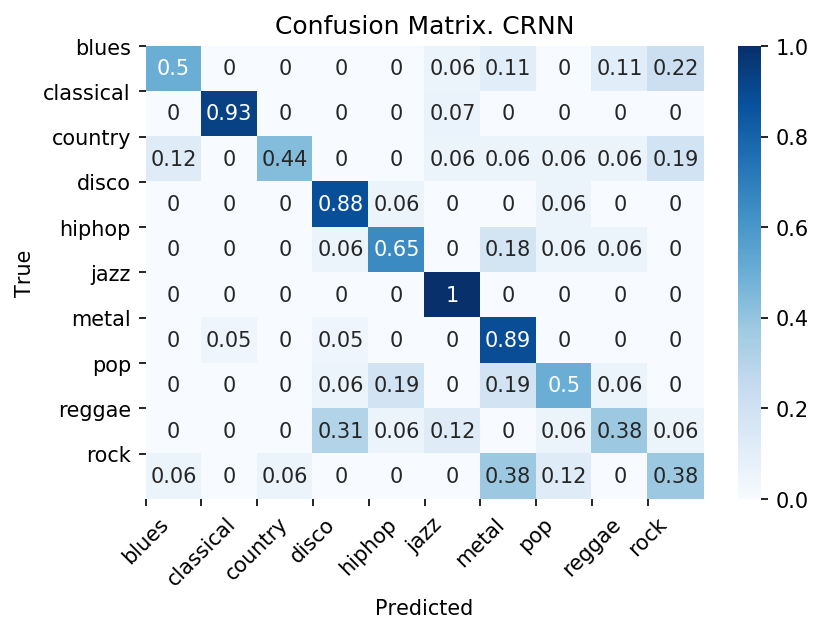

In [80]:
y_pred_crnn = np.argmax(preds_crnn, axis=1)
plot_cm(y_test, y_pred_crnn, np.array(genres)[g_to_anfis], labels_order=g_to_anfis, title='Confusion Matrix. CRNN')

In [81]:
res_vals_crnn = []
for i in g_to_anfis:
    args = np.where(y_test == i)
    res_vals_crnn.append(accuracy_score(y_test[args], y_pred_crnn[args]))
res_vals_crnn = np.around(np.array(res_vals_crnn), 3)

In [82]:
res_vals_crnn

array([ 0.5  ,  0.933,  0.438,  0.882,  0.647,  1.   ,  0.895,  0.5  ,
        0.375,  0.375])

### All results

In [85]:
res_df = pd.DataFrame(np.column_stack((list(genres_map_anfis.keys()), res_vals_rfc, res_vals_mlp, anfis_scaled_res, 
                                       res_vals_cnn, res_vals_crnn)), 
                      columns=['Genre', 'RF', 'MLP', 'ANFIS', 'CNN', 'CRNN'])
res_df.set_index(['Genre'])


,RF,MLP,ANFIS,CNN,CRNN
Genre,,,,,
blues,0.64,0.56,0.684,0.722,0.5
classical,0.88,0.8,1.0,0.933,0.933
country,0.52,0.56,0.733,0.75,0.438
disco,0.44,0.52,0.633,1.0,0.882
hiphop,0.52,0.64,0.826,0.824,0.647
jazz,0.8,0.76,0.667,0.933,1.0
metal,0.64,0.72,0.938,1.0,0.895
pop,0.6,0.72,0.864,0.562,0.5
reggae,0.8,0.72,0.739,0.75,0.375


In [74]:
res_df[['ANFIS', 'CNN', 'CRNN']] = res_df[['ANFIS', 'CNN', 'CRNN']].astype(float)

In [75]:
res_df.mean()

ANFIS    0.7340
CNN      0.8162
CRNN     0.6545
dtype: float64

In [87]:
res_df[list(set(res_df.columns) - set(['Genre']))] = res_df[list(set(res_df.columns) - set(['Genre']))].astype(float)
res_df.mean(axis=0)

RF       0.6320
MLP      0.6600
ANFIS    0.7677
CNN      0.8162
CRNN     0.6545
dtype: float64